A2C: https://github.com/higgsfield/RL-Adventure-2/blob/master/1.actor-critic.ipynb

Actor Critic code from Pytorch https://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py
https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py

Actual algorithm pseudocode: https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#actor-critic

In [0]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from jax import jacobian, lax
import jax
import jax.numpy as jp
from jax.ops import index, index_add, index_update
from jax import jit, grad, vmap, random, jacrev, jacobian, jacfwd, value_and_grad
from functools import partial
from jax.experimental import stax # neural network library
from jax.experimental.stax import GeneralConv, Conv, ConvTranspose, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu, Dropout, Tanh, Sigmoid, BatchNorm, Softmax # neural network layers
from jax.nn import softmax, sigmoid
from jax.nn.initializers import zeros
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays

In [0]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return jp.array(x[:, None] == jp.arange(k), dtype)

def cumulative_rewards(rewards, gamma):
    returns = jp.zeros(len(rewards))
    next_return = 0 # 0 because we start at the last timestep
    for t in reversed(range(0, len(rewards))):
        next_return = rewards[t] + gamma * next_return
        returns = index_update(returns, index[t], next_return)
    # normalize for better statistical properties
    returns = (returns - returns.mean()) / (returns.std() + jp.finfo(jp.float32).eps)
    return returns

class Policy:
    def __init__(self, rng, a_size=2, s_size=4, lr=1e-3):
        super(Policy, self).__init__()
        self.key = rng

        #Actor network
        self.actor_init, self.actor_apply = stax.serial(
            Dense(128), Dense(256), Dense(a_size), Softmax
        )
        self.actor_in_shape = (-1, s_size)
        self.actor_opt_init, self.actor_opt_update, self.actor_get_params = optimizers.adam(step_size=lr)
        _, self.actor_params = self.actor_init(self.key, self.actor_in_shape)
        self.actor_opt_state = self.actor_opt_init(self.actor_params)

        #Critic network
        self.critic_init, self.critic_apply = stax.serial(
            Dense(128), Dense(256), Dense(1)
        )
        self.critic_in_shape = (-1, s_size)
        self.critic_opt_init, self.critic_opt_update, self.critic_get_params = optimizers.adam(step_size=lr)
        _, self.critic_params = self.critic_init(self.key, self.critic_in_shape)
        self.critic_opt_state = self.critic_opt_init(self.critic_params)

        self.opt_t = 1
        self.num_actions = a_size

        def loss_fn(actor_params, critic_params, sar):
            one_hot_actions = one_hot(sar['a'], self.num_actions)
            probs = self.actor_apply(actor_params, sar['s'])
            values = self.critic_apply(critic_params, sar['s'])
            advantage = sar['r'] - values.reshape(sar['r'].shape)
            # print(one_hot_actions.shape, probs.shape, advantage.shape, sar['r'].shape, values.shape)
            actor_loss = jp.einsum('ij,i->',- one_hot_actions * jp.log(probs), jax.lax.stop_gradient(advantage))
            critic_loss = jp.mean(advantage**2)
            return actor_loss, critic_loss

        @jit
        def step_fn(i, actor_opt_state, critic_opt_state, sar):
            actor_params = self.actor_get_params(actor_opt_state)
            critic_params = self.critic_get_params(critic_opt_state)
            actor_loss = lambda x: loss_fn(x, critic_params, sar)[0]
            critic_loss = lambda y: loss_fn(actor_params, y, sar)[1]
            al, ag = value_and_grad(actor_loss)(actor_params)
            cl, cg = value_and_grad(critic_loss)(critic_params)
            return self.actor_opt_update(i, ag, actor_opt_state), self.critic_opt_update(i, cg, critic_opt_state), al, cl 
        self.step = step_fn


    def update_key(self):
        self.key, _ = jax.random.split(self.key)
        return self.key

    def act(self, state):
        probs = self.actor_apply(self.actor_params, state)
        uf = jax.random.uniform(self.update_key(), (1,), minval=0.0, maxval=1.0)[0]
        action = jp.argmax(uf < jp.cumsum(probs))
        return action.item()

    def value(self, state):
        return self.critic_apply(self.critic_params, state)

    def update(self, sar, gamma=1.0):
        sar['r'] = cumulative_rewards(sar['r'], gamma)
        sar['s'] = jp.array(sar['s'])
        sar['a'] = jp.array(sar['a'])

        self.actor_opt_state, self.critic_opt_state, actor_loss, critic_loss = self.step(self.opt_t, self.actor_opt_state, self.critic_opt_state, sar)
        self.opt_t += 1
        self.actor_params = self.actor_get_params(self.actor_opt_state)
        self.critic_params = self.critic_get_params(self.critic_opt_state)

        return actor_loss, critic_loss



In [0]:
def train(env, policy, n_episodes=10000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        # print(f"Episode {i_episode}")
        saved_log_probs = []
        rewards = []
        values = []
        sar = {key: [] for key in 'sarv'}
        state = env.reset()
        # print(f'State:{state}')
        for t in range(max_t):
            action = policy.act(state)
            sar['s'].append(state)
            sar['a'].append(action)
            state, reward, done, _ = env.step(action)
            sar['r'].append(reward)
            rewards.append(reward)
            if done:
                # print(f'Done {t}')
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        al, cl = policy.update(sar, gamma)
        # print(f'loss {l}')
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores

def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()


observation space: Box(4,)
action space: 2
Episode 100	Average Score: 86.70
Episode 200	Average Score: 131.81
Episode 300	Average Score: 169.60
Environment solved in 233 episodes!	Average Score: 195.50


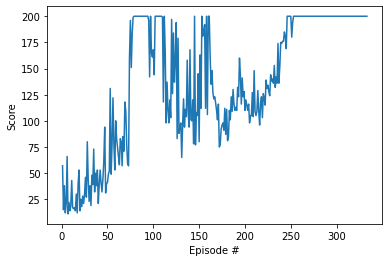

In [0]:
def main():
    env = gym.make('CartPole-v0')
    env.seed(0)
    print('observation space:', env.observation_space)
    print('action space:', env.action_space.n)
    rng = jax.random.PRNGKey(0)
    pi = Policy(rng, env.action_space.n, lr=1e-3)
    scores = train(env, pi)
    plot_scores(scores)

if __name__ == '__main__':
    main()